# Tutorial: data procesing
Author info: Jiaqi Cai@Department of Physics, MIT, email address jiaqic[at]mit.edu.

This tutorial shows how to use this package to perform multidimensional data analysis. The example_database is generated by quick start. 

# Database initialization
First, we list all available databases under measureit.get_path("databases") and show the standard qcodes way to initialize and load databases.


In [1]:
# Standard QCoDeS imports for database and dataset operations
import numpy as np

# Core QCoDeS imports
import qcodes as qc
from qcodes.dataset import initialise_or_create_database_at, load_by_id
from measureit import get_path

# MeasureIt imports

print(f"QCoDeS version: {qc.__version__}")
print(f"Current QCoDeS database location: {qc.config.core.db_location}")


MeasureIt data directory: /home/wangs/instrmcptest
To change: measureit.set_data_dir('/path')

QCoDeS version: 0.54.1
Current QCoDeS database location: ~/experiments.db


In [2]:
databases_path = get_path("databases")
db_files = sorted(databases_path.glob("*.db"))
print(f"🗃️ Database files in {databases_path}:")
print("=" * 50)
for i, db_file in enumerate(db_files, 1):
    print(f"{i:2}. {db_file.name}")

🗃️ Database files in /home/wangs/instrmcptest/Databases:
 1. Test_SweepQueue_DB1.db
 2. Test_SweepQueue_DB2.db
 3. Test_database.db


In [3]:
# Choose a database file (replace with your desired .db file)
databases_path = get_path("databases")
db_file = databases_path / "Test_database.db"

# Load the database
initialise_or_create_database_at(db_file)
print(f"📊 Loaded database: {db_file.name}")

# Show experiments in the database

📊 Loaded database: Test_database.db


## List experiments and datasets

In [4]:
from measureit.visualization import helper

dataset = load_by_id(1)
helper.print_metadata(dataset)

In [5]:
helper.print_all_metadata()

# Plot 0D

In [6]:
dataset = load_by_id(1)
helper.print_metadata(dataset)

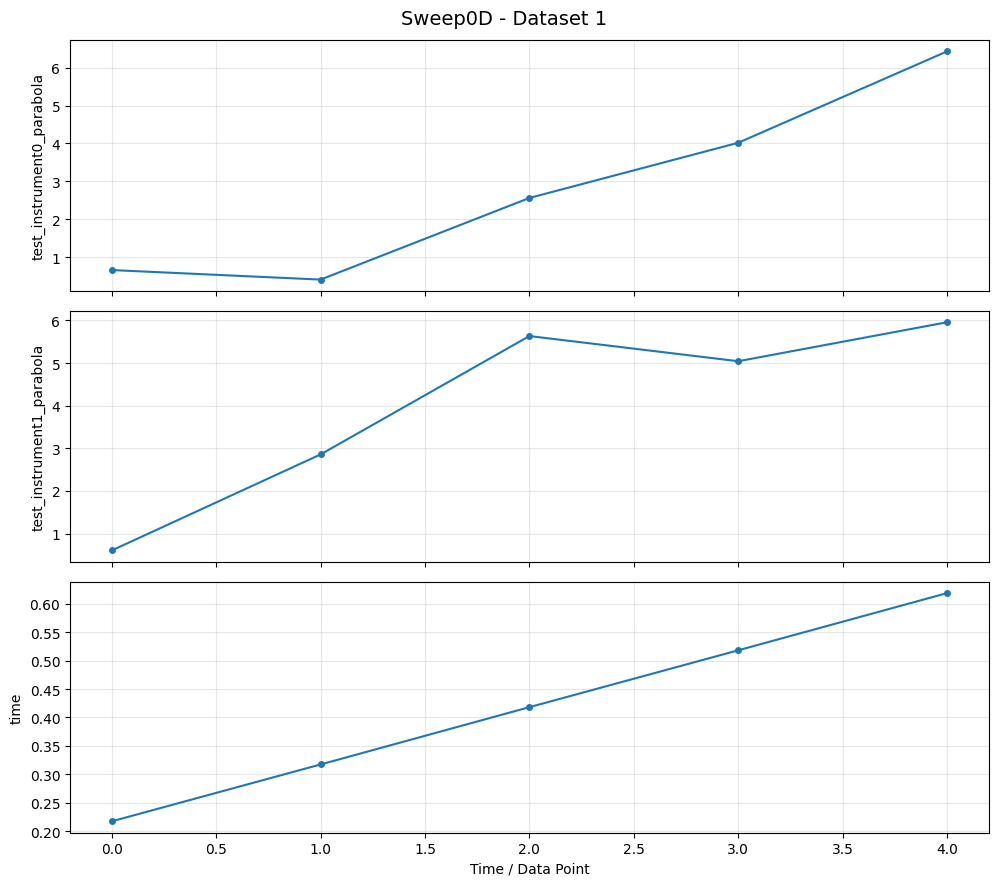

In [7]:
import matplotlib.pyplot as plt

data = dataset.get_parameter_data()
n_params = len(data)
fig, axes = plt.subplots(n_params, 1, figsize=(10, 3 * n_params), sharex=True)

if n_params == 1:
    axes = [axes]

for ax, (param_name, param_data) in zip(axes, data.items()):
    values = list(param_data.values())[0]
    ax.plot(values, "o-", markersize=4)
    ax.set_ylabel(param_name)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Time / Data Point")
fig.suptitle(f"Sweep0D - Dataset {dataset.run_id}", fontsize=14)
plt.tight_layout()
plt.show()

# Plot 1D

In [10]:
dataset = load_by_id(2)
helper.print_metadata(dataset)

In [11]:
import json

import matplotlib.pyplot as plt

data = dataset.get_parameter_data()
metadata = json.loads(dataset.metadata["measureit"])
x_param_info = metadata["set_param"]
x_param_name = f"{x_param_info['instr_name']}_{x_param_info['param']}"
is_bidirectional = metadata["attributes"].get("bidirectional", False)

# Get x data from any parameter that has it as setpoint
x_data = None
for param_data in data.values():
    if x_param_name in param_data:
        x_data = param_data[x_param_name]
        break

measured_params = [p for p in data.keys() if p != "time"]
n_params = len(measured_params)
fig, axes = plt.subplots(n_params, 1, figsize=(10, 3 * n_params), sharex=True)

if n_params == 1:
    axes = [axes]

for ax, param_name in zip(axes, measured_params):
    y_data = data[param_name][param_name]

    if is_bidirectional:
        # Plot forward and backward sweep differently
        mid_point = len(x_data) // 2
        ax.plot(
            x_data[:mid_point],
            y_data[:mid_point],
            "o-",
            markersize=3,
            label="Forward",
            alpha=0.8,
        )
        ax.plot(
            x_data[mid_point:],
            y_data[mid_point:],
            "s-",
            markersize=3,
            label="Backward",
            alpha=0.8,
        )
        ax.legend()
    else:
        ax.plot(x_data, y_data, "o-", markersize=4)

    ax.set_ylabel(param_name)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel(x_param_name)
title = f"Sweep1D {'(Bidirectional)' if is_bidirectional else ''} - Dataset {dataset.run_id}"
fig.suptitle(title, fontsize=14)
plt.tight_layout()
plt.show()

KeyError: 'set_param'

## Plot Simul

In [13]:
dataset = load_by_id(3)
helper.print_metadata(dataset)

In [14]:
metadata

{'class': 'Sweep1D',
 'module': 'measureit.sweep.sweep1d',
 'attributes': {'inter_delay': 0.05,
  'save_data': True,
  'plot_data': True,
  'plot_bin': 4,
  'bidirectional': True,
  'continual': False,
  'x_axis_time': 0},
 'set_param': {'param': 'x',
  'instr_module': 'qcodes.instrument_drivers.mock_instruments',
  'instr_class': 'MockParabola',
  'instr_name': 'test_instrument0',
  'start': 0,
  'stop': 10,
  'step': 0.02},
 'follow_params': {'test_instrument0.parabola': ['test_instrument0',
   'qcodes.instrument_drivers.mock_instruments',
   'MockParabola'],
  'test_instrument1.parabola': ['test_instrument1',
   'qcodes.instrument_drivers.mock_instruments',
   'MockParabola']}}

Found 2 set parameters: ['test_instrument0_x', 'test_instrument1_x']
Found 3 follow parameters: ['test_instrument0_parabola', 'test_instrument1_parabola', 'test_instrument1_x']


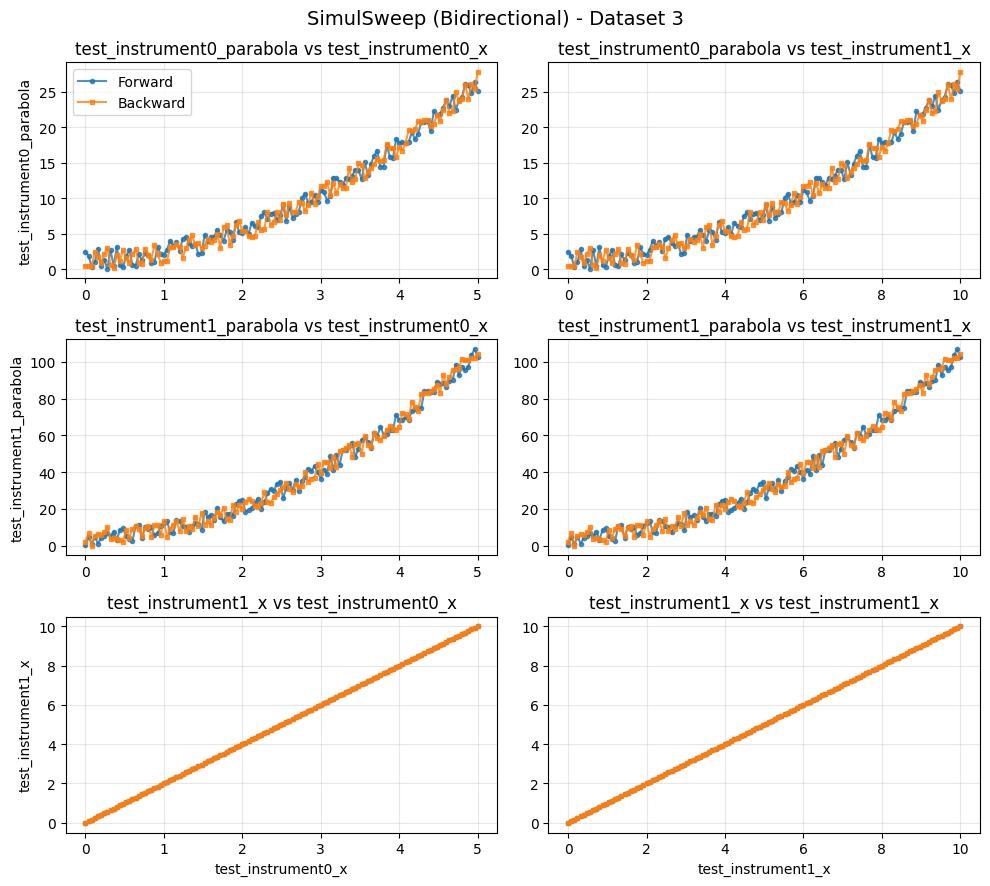

In [15]:
import json

import matplotlib.pyplot as plt

data = dataset.get_parameter_data()
metadata = json.loads(dataset.metadata["measureit"])
set_params = metadata["set_params"]
is_bidirectional = metadata["attributes"].get("bidirectional", False)

# Get all set parameter names and their data
x_params_data = {}
for full_param_name, info in set_params.items():
    # Extract just the parameter name (e.g., 'x' from 'test_instrument0.x')
    param_name = full_param_name.split(".")[-1]
    instr_name = info["instr_name"]
    param_full_name = f"{instr_name}_{param_name}"

    # Find this parameter in any of the data entries
    for data_key, data_dict in data.items():
        if param_full_name in data_dict:
            x_params_data[param_full_name] = data_dict[param_full_name]
            break

# Get follow parameter names (excluding time)
follow_param_names = [p for p in data.keys() if p != "time"]

n_x = len(x_params_data)
n_follow = len(follow_param_names)

print(f"Found {n_x} set parameters: {list(x_params_data.keys())}")
print(f"Found {n_follow} follow parameters: {follow_param_names}")

fig, axes = plt.subplots(n_follow, n_x, figsize=(5 * n_x, 3 * n_follow))

if n_x == 1 and n_follow == 1:
    axes = [[axes]]
elif n_x == 1:
    axes = [[ax] for ax in axes]
elif n_follow == 1:
    axes = [axes]

for i, follow_param in enumerate(follow_param_names):
    y_data = data[follow_param][follow_param]

    for j, (x_param_name, x_data) in enumerate(x_params_data.items()):
        if is_bidirectional:
            # Plot forward and backward sweep differently
            mid_point = len(x_data) // 2
            axes[i][j].plot(
                x_data[:mid_point],
                y_data[:mid_point],
                "o-",
                markersize=3,
                label="Forward",
                alpha=0.8,
            )
            axes[i][j].plot(
                x_data[mid_point:],
                y_data[mid_point:],
                "s-",
                markersize=3,
                label="Backward",
                alpha=0.8,
            )
            if i == 0 and j == 0:  # Only show legend once
                axes[i][j].legend()
        else:
            axes[i][j].plot(x_data, y_data, "o-", markersize=4)

        axes[i][j].set_ylabel(follow_param if j == 0 else "")
        axes[i][j].set_xlabel(x_param_name if i == n_follow - 1 else "")
        axes[i][j].set_title(f"{follow_param} vs {x_param_name}")
        axes[i][j].grid(True, alpha=0.3)

title = f"SimulSweep {'(Bidirectional)' if is_bidirectional else ''} - Dataset {dataset.run_id}"
fig.suptitle(title, fontsize=14)
plt.tight_layout()
plt.show()

# Plot 2D

In [16]:
dataset = load_by_id(6)
helper.print_metadata(dataset)

In [19]:
metadata

{'class': 'Sweep2D',
 'module': 'measureit.sweep.sweep2d',
 'attributes': {'inter_delay': 0.1,
  'save_data': True,
  'plot_data': True,
  'plot_bin': 5,
  'outer_delay': 0.5},
 'inner_sweep': {'param': 'x',
  'param_key': 'test_instrument0.x',
  'instr_module': 'qcodes.instrument_drivers.mock_instruments',
  'instr_class': 'MockParabola',
  'instr_name': 'test_instrument0',
  'start': -2.5,
  'stop': 2.5,
  'step': 0.1},
 'outer_sweep': {'param': 'y',
  'param_key': 'test_instrument0.y',
  'instr_module': 'qcodes.instrument_drivers.mock_instruments',
  'instr_class': 'MockParabola',
  'instr_name': 'test_instrument0',
  'start': -2.5,
  'stop': 2.5,
  'step': 0.5},
 'follow_params': {'test_instrument0.parabola': ['test_instrument0',
   'qcodes.instrument_drivers.mock_instruments',
   'MockParabola'],
  'test_instrument1.parabola': ['test_instrument1',
   'qcodes.instrument_drivers.mock_instruments',
   'MockParabola']}}

QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull d Qt Qz Qc Qbb Q12
Options selected for Qhull 2020.2.r 2020/08/31:
  run-id 991423691  delaunay  Qtriangulate  Qz-infinity-point  Qcoplanar-keep
  Qbbound-last  Q12-allow-wide  _pre-merge  _zero-centrum  Qinterior-keep
  Pgood  _max-width  5  Error-roundoff 3.5e-15  _one-merge 2.4e-14
  Visible-distance 6.9e-15  U-max-coplanar 6.9e-15  Width-outside 1.4e-14
  _wide-facet 4.2e-14  _maxoutside 2.8e-14

The input to qhull appears to be less than 3 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p64(v4):  0.02  -2.5   2.5
- p25(v3): 1.1e-15  -2.5     0
- p50(v2):   2.5  -2.5   2.1
- p0(v1):  -2.5  -2.5   2.1

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 3.5e-15.  The center point, facets and distances
to the center point are as follows:

center point 0.005078     -2.5    1.667

facet p25 p50 p0 distance=    0
facet p64 p50 p0 distance=    0
facet p64 p25 p0 distance=    0
facet p64 p25 p50 distance=    0

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:      -2.5       2.5  difference=    5
  1:      -2.5  -2.225e-308  difference=  2.5
  2:         0       2.5  difference=  2.5

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 3.5e-15.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


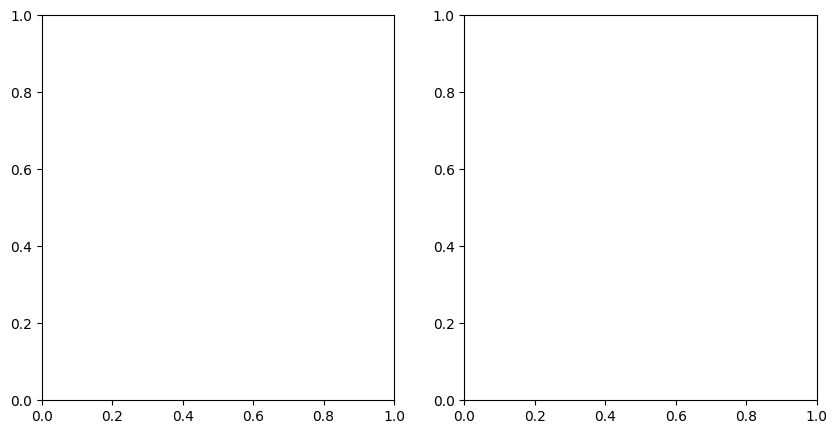

In [18]:
import json

import matplotlib.pyplot as plt
from scipy.interpolate import griddata

data = dataset.get_parameter_data()
metadata = json.loads(dataset.metadata["measureit"])

# Get inner and outer sweep parameters from metadata
inner_param_name = (
    f"{metadata['inner_sweep']['instr_name']}_{metadata['inner_sweep']['param']}"
)
outer_param_name = (
    f"{metadata['outer_sweep']['instr_name']}_{metadata['outer_sweep']['param']}"
)

# Get coordinate data from any parameter that has both setpoints
coord_data = None
for param_name, param_dict in data.items():
    if inner_param_name in param_dict and outer_param_name in param_dict:
        coord_data = param_dict
        break

x_data = coord_data[inner_param_name]  # Inner sweep (x-axis)
y_data = coord_data[outer_param_name]  # Outer sweep (y-axis)

# Get follow parameters (exclude time and sweep parameters)
follow_params = [
    p
    for p in data.keys()
    if p != "time" and p != inner_param_name and p != outer_param_name
]
n_follow = len(follow_params)

# Create regular grid for pcolormesh
x_unique = np.unique(x_data)
y_unique = np.unique(y_data)
X, Y = np.meshgrid(x_unique, y_unique)

fig, axes = plt.subplots(1, n_follow, figsize=(5 * n_follow, 5))
if n_follow == 1:
    axes = [axes]

for i, param_name in enumerate(follow_params):
    z_data = data[param_name][param_name]

    # Interpolate irregular data to regular grid
    Z = griddata((x_data, y_data), z_data, (X, Y), method="linear")

    # Create 2D heatmap using pcolormesh
    im = axes[i].pcolormesh(X, Y, Z, shading="auto", cmap="viridis")
    axes[i].set_xlabel(inner_param_name)
    axes[i].set_ylabel(outer_param_name if i == 0 else "")
    axes[i].set_title(param_name)

    # Add colorbar
    plt.colorbar(im, ax=axes[i])

fig.suptitle(f"Sweep2D - Dataset {dataset.run_id}", fontsize=14)
plt.tight_layout()
plt.show()